In [1]:
# https://lemire.me/blog/2019/12/12/are-64-bit-random-identifiers-free-from-collision/
from decimal import *
from math import exp

getcontext().prec = 24

def birthday(r,N):
    return Decimal(1)-Decimal(Decimal(-r)**Decimal(2)/(Decimal(2)*(Decimal(2)**Decimal(N)))).exp()
                              
birthday(1_000_000_000,128)*100

Decimal('-1.4700E-19')

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

In [3]:
result_file = Path("uuid_load_test_result.parquet.gzip")
if result_file.is_file():
    df = pd.read_parquet(result_file)
else:
    results = pd.read_csv("../../../out/uuid_load_test_result.csv")
    results['row_found'] = (results.bytes != 23) # miss
    df = results[['timeStamp', 'elapsed', 'label','Latency','Connect','row_found']]    
    df.to_parquet(result_file,compression='gzip')

In [4]:
ds = df.groupby('label')['elapsed'].describe(include='all')
ds['range'] = ds['max']-ds['min']
ds['IQR'] = ds['75%']-ds['25%']
ds


count       mean        std  min   25%  \
label                                                                         
Query uuid_test by idb           1000000.0  26.879362  22.859803  0.0  10.0   
Query uuid_test by idb with ids  1000000.0  28.973836  23.343375  1.0  12.0   
Query uuid_test by idn           1000000.0  29.007686  26.848542  0.0  11.0   
Query uuid_test by ids           1000000.0  30.744589  29.169231  0.0  11.0   

                                  50%   75%     max   range   IQR  
label                                                              
Query uuid_test by idb           22.0  38.0   623.0   623.0  28.0  
Query uuid_test by idb with ids  24.0  40.0   640.0   639.0  28.0  
Query uuid_test by idn           23.0  41.0  2092.0  2092.0  30.0  
Query uuid_test by ids           24.0  42.0  1707.0  1707.0  31.0

In [5]:
def is_outlier(s):
#     lower_limit = s.mean() - (s.std() * 3)
#     upper_limit = s.mean() + (s.std() * 3)
    lower_limit = s.quantile(.01)
    upper_limit = s.quantile(.99)
    return ~s.between(lower_limit, upper_limit)

df_no_outliers = df[~df.groupby('label')['elapsed'].apply(is_outlier)]
ds_no_outliers = df_no_outliers.groupby('label')['elapsed'].describe()
ds_no_outliers

count       mean        std  min   25%  \
label                                                                        
Query uuid_test by idb           990118.0  25.850371  19.912166  1.0  10.0   
Query uuid_test by idb with ids  989944.0  27.939510  20.454155  2.0  12.0   
Query uuid_test by idn           990007.0  27.844932  21.660075  1.0  10.0   
Query uuid_test by ids           980565.0  29.383033  22.969392  2.0  12.0   

                                  50%   75%    max  
label                                               
Query uuid_test by idb           21.0  37.0   98.0  
Query uuid_test by idb with ids  23.0  40.0  101.0  
Query uuid_test by idn           23.0  40.0  105.0  
Query uuid_test by ids           24.0  42.0  127.0

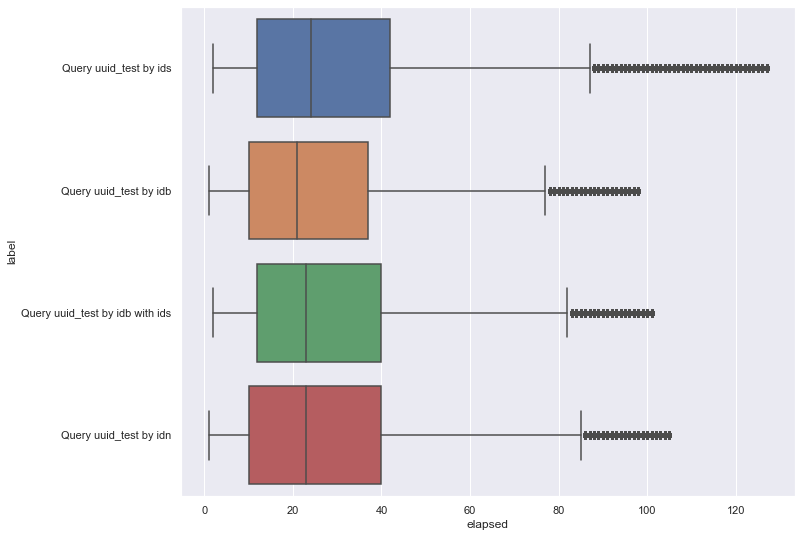

In [6]:
_ = plt.figure(figsize=(11, 9))
_ = sns.boxplot(y="label", x="elapsed", data=df_no_outliers, orient="h")
_.figure.savefig("../../docs/images/uuid_load_test_result_boxplot.png", bbox_inches='tight')